In [1]:
import torch
import torch.nn as nn
import torchdiffeq
import dgl
import numpy as np
import scipy.sparse as sp
import matplotlib.pyplot as plt

/home/suitang/transfer_gde/gde/env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#Define the GCNLayer class with time-dependent weights and K-step message passing
class GCNLayer(nn.Module):
    def __init__(self, g: dgl.DGLGraph, in_feats: int, out_feats: int, activation: nn.Module, dropout: float, time_fn: callable = torch.sin, K: int = 1, bias: bool = True):
        super().__init__()
        self.g = g
        self.in_feats = in_feats
        self.out_feats = out_feats
        self.weight = nn.Parameter(torch.Tensor(in_feats, out_feats))
        self.time_fn = time_fn
        self.K = K
        if bias:
            self.bias = nn.Parameter(torch.Tensor(out_feats))
        else:
            self.bias = None
        self.activation = activation
        self.dropout = nn.Dropout(p=dropout) if dropout else nn.Identity()
        self.reset_parameters()

    def reset_parameters(self):
        stdv = 1. / (self.weight.size(1) ** 0.5)
        self.weight.data.uniform_(-stdv, stdv)
        if self.bias is not None:
            self.bias.data.uniform_(-stdv, stdv)

    def forward(self, h, t):
        if isinstance(self.dropout, nn.Dropout):
            h = self.dropout(h)
        
        #Use the passed time-dependent function
        modulated_weight = self.weight * self.time_fn(t)

        h = torch.mm(h, modulated_weight)

        #Perform message passing  using graph filters defined by the adjacent matrix
        for _ in range(self.K):
            #h = h * self.g.ndata['norm']
            self.g.ndata['h'] = h/self.g.number_of_nodes()
            self.g.update_all(dgl.function.copy_u(u='h', out='m'), dgl.function.sum(msg='m', out='h'))
            h = self.g.ndata.pop('h')
            #h = h * self.g.ndata['norm']
        
        if self.bias is not None:
            h = h + self.bias
        if self.activation:
            h = self.activation(h)
        return h


# Custom Sequential module to handle additional arguments
class TimeDependentSequential(nn.Sequential):
    def forward(self, input, t):
        for module in self:
            input = module(input, t)
        return input

# Function to create adjacency matrix using the Chung-Lu graphon
def create_chung_lu_adj_matrix(N, beta):
    points = np.linspace(0, 1, N)
    adj_matrix = np.zeros((N, N))
    for i in range(N):
        for j in range(N):
            if (points[i] + points[j]) % 1 < beta:
                adj_matrix[i, j] = 1
    np.fill_diagonal(adj_matrix, 0)
    return adj_matrix

# Create a simple DGL graph
def create_example_graph(N, beta):
    adj_matrix = create_chung_lu_adj_matrix(N, beta)
    g = dgl.from_scipy(sp.coo_matrix(adj_matrix))
    degs = g.in_degrees().float()
    norm = torch.pow(degs, -0.5)
    norm[torch.isinf(norm)] = 0
    g.ndata['norm'] = norm.unsqueeze(1)
    return g

# Define the GDE function class with time-dependent weights
class GDEFunc(nn.Module):
    def __init__(self, gnn: nn.Module):
        """General GDE function class. To be passed to an ODEBlock"""
        super().__init__()
        self.gnn = gnn
        self.nfe = 0
    
    def set_graph(self, g: dgl.DGLGraph):
        for layer in self.gnn:
            layer.g = g
            
    def forward(self, t, x):
        self.nfe += 1
        x = self.gnn(x, t)
        return x

# Define the ODEBlock class
class ODEBlock(nn.Module):
    def __init__(self, odefunc: nn.Module, method: str = 'dopri5', rtol: float = 1e-3, atol: float = 1e-4, adjoint: bool = True):
        """Standard ODEBlock class. Can handle all types of ODE functions
        :method: str = {'euler', 'rk4', 'dopri5', 'adams'}
        """
        super().__init__()
        self.odefunc = odefunc
        self.method = method
        self.adjoint_flag = adjoint
        self.atol, self.rtol = atol, rtol

    def forward(self, x: torch.Tensor, T: int):
        self.integration_time = torch.tensor([0, T]).float()
        self.integration_time = self.integration_time.type_as(x)

        if self.adjoint_flag:
            out = torchdiffeq.odeint_adjoint(self.odefunc, x, self.integration_time,
                                             rtol=self.rtol, atol=self.atol, method=self.method)
        else:
            out = torchdiffeq.odeint(self.odefunc, x, self.integration_time,
                                     rtol=self.rtol, atol=self.atol, method=self.method)
            
        return out[-1]
    
    def forward_batched(self, x: torch.Tensor, nn: int, indices: list, timestamps: set):
        """Modified forward for ODE batches with different integration times"""
        timestamps = torch.Tensor(list(timestamps))
        if self.adjoint_flag:
            out = torchdiffeq.odeint_adjoint(self.odefunc, x, timestamps,
                                             rtol=self.rtol, atol=self.atol, method=self.method)
        else:
            out = torchdiffeq.odeint(self.odefunc, x, timestamps,
                                     rtol=self.rtol, atol=self.atol, method=self.method)

        out = self._build_batch(out, nn, indices).reshape(x.shape)
        return out
    
    def _build_batch(self, odeout, nn, indices):
        b_out = []
        for i in range(len(indices)):
            b_out.append(odeout[indices[i], i*nn:(i+1)*nn])
        return torch.cat(b_out).to(odeout.device)
              
    def trajectory(self, x: torch.Tensor, T: int, num_points: int):
        self.integration_time = torch.linspace(0, T, num_points)
        self.integration_time = self.integration_time.type_as(x)
        out = torchdiffeq.odeint(self.odefunc, x, self.integration_time,
                                 rtol=self.rtol, atol=self.atol, method=self.method)
        return out

# Define the piecewise constant function
def piecewise_constant(u, v):
    n = len(v)
    interval_length = 1.0 / n
    for i in range(n):
        if u >= i * interval_length and u < (i + 1) * interval_length:
            return v[i]
    return v[-1]  # For u == 1, return the last element of v
#Function to generate feature matrix.
#This applies each function in func_list to each sample point in sample_points.
#This way, the entire feature matrix is made at once.
def generate_features(sample_points, t, func_list):

    num_points = len(sample_points)
    num_features = len(func_list)
    
    # Initialize an array to store feature vectors
    feature_matrix = np.zeros((num_points, num_features))
    
    # Generate features for each sample point
    for i, u in enumerate(sample_points):
        features = [func(u, t) for func in func_list]
        feature_matrix[i, :] = np.concatenate(features)
    
    return feature_matrix

# Device setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
#Create the largest graph first:
N = 10000
beta = 0.5
g = create_example_graph(N, beta)
g = g.to(device)

#Define message passing neighborhood and num node features
#These are shared through all architectures.
K_val = 1
node_features = 3

#Some example weight modulation functions for testing:
def sin_fn(t):
    return torch.sin(t)
def periodic_fn(t):
    return torch.cos(t) + torch.sin(t)
def lin_fn(t):
    return t + 1

weight_modulation_fn = sin_fn

# Define the largest GNN with the custom TimeDependentSequential
gnn = TimeDependentSequential(
    GCNLayer(g=g, in_feats=node_features, out_feats= 3, activation=nn.Softplus(), dropout=0, time_fn=weight_modulation_fn, K=K_val),
    GCNLayer(g=g, in_feats=3, out_feats=node_features, activation=nn.Softplus(), dropout=0, time_fn=weight_modulation_fn, K=K_val),
   # GCNLayer(g=g, in_feats=64, out_feats=node_features, activation=None, dropout=0, time_fn=weight_modulation_fn, K=K_val)
).to(device)

# Initialize GDEFunc with the GNN
gde_func = GDEFunc(gnn)

# Initialize ODEBlock with GDEFunc
# Note: I changed the integrator to match with the smaller models, as dopri5 was being used here.
# Dopri5 seems to be a constant factor off from the rk4 output on this problem.
gde = ODEBlock(gde_func, method='dopri5', atol=1e-9, rtol=1e-10, adjoint=False)


original_parameters = {name: param.clone() for name, param in gnn.named_parameters()}
# Sample points from [0, 1]
N = g.num_nodes() # Number of nodes
sample_points = np.linspace(0, 1, N)

#Example 1D functions for feature generation
def func1(u, t):
    return np.array([np.sin(2 * np.pi * u + t)])

def func2(u, t):
    return np.array([np.cos(2 * np.pi * u - t)])

def func3(u, t):
    return np.array([2*u + 0.2])

#List of these 1D functions
func_list = [func1, func2, func3]

#Sample points from [0, 1]
N = g.num_nodes() # Number of nodes
sample_points = np.linspace(0, 1, N)

# Define time t
t = 0.0

# Generate feature vectors for each sample point
feature_vectors = generate_features(sample_points, t, func_list)

# Convert feature vectors to PyTorch tensor
features = torch.tensor(feature_vectors, dtype=torch.float32)
print(features.shape)  # Should match (N, number of functions)

# Move the graph and features to the same device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
g = g.to(device)
features = features.to(device)

# Add feature vectors to the graph
g.ndata['feat'] = features


X1: torch.Tensor =  features.to(device)
Y1 = gde(X1,10)
X1_cpu = X1.cpu().detach().numpy()
Y1_cpu = Y1.cpu().detach().numpy()

torch.Size([10000, 3])


In [15]:
#Next, make several smaller models to compare errors.
graph_sizes = list(range(1200,2000, 200))


#Print list of graph sizes.
print(graph_sizes)

#Populate an array with the graphs and models created.
smaller_graphs_and_models = []

for size in graph_sizes:

    # Create a new graph using the adjacency matrix
    g_new = create_example_graph(int(size), 0.5)
    g_new = g_new.to(device)
    g_new= dgl.remove_self_loop(g_new)
    g_new = dgl.add_self_loop(g_new).to(device)
    n_edges = g_new.number_of_edges()
    print(f"Number of edges: {n_edges}")
    g_new = g_new.to(device)
    degs = g_new.in_degrees().float()
    norm = torch.pow(degs, -0.5)
    norm[torch.isinf(norm)] = 0
    g_new.ndata['norm'] = norm.unsqueeze(1).to(device)

    # Define the new GNN
    new_gnn = TimeDependentSequential(
        GCNLayer(g=g_new, in_feats=node_features, out_feats= 3, activation=nn.Softplus(), dropout=0, time_fn=weight_modulation_fn, K=K_val),
        GCNLayer(g=g_new, in_feats= 3, out_feats=node_features, activation=nn.Softplus(), dropout=0, time_fn=weight_modulation_fn, K=K_val),
       # GCNLayer(g=g_new, in_feats=64, out_feats=node_features, activation=None, dropout=0, time_fn=weight_modulation_fn, K=K_val)
    ).to(device)

    
    # Apply the extracted parameters to the new GNN
    for name, param in original_parameters.items():
        if name in new_gnn.state_dict():
            new_gnn.state_dict()[name].copy_(param.data)

    # Verify the parameters have been copied correctly
    for (name1, param1), (name2, param2) in zip(gnn.named_parameters(), new_gnn.named_parameters()):
        assert torch.equal(param1, param2), f"Mismatch in parameter {name1}"
    print("Parameters copied successfully!")

    new_gdefunc = GDEFunc(new_gnn).to(device)
    new_gde = ODEBlock(odefunc=new_gdefunc, method='dopri5', atol=1e-9, rtol=1e-10, adjoint=False).to(device)

    smaller_graphs_and_models.append([g_new, new_gde])

[1200, 1400, 1600, 1800]


Number of edges: 720978
Parameters copied successfully!
Number of edges: 981400
Parameters copied successfully!
Number of edges: 1281600
Parameters copied successfully!
Number of edges: 1621418
Parameters copied successfully!


In [16]:
#Next, generate features for all smaller models also:
for i, (graph, model) in enumerate(smaller_graphs_and_models):

    # Sample points from [0, 1]
    N = graph.num_nodes()
    sample_points = np.linspace(0, 1, N)

    #Same example time t
    t = 0.0

    #Generate feature vectors for each sample point
    feature_vectors = generate_features(sample_points, t, func_list)

    #Convert feature vectors to PyTorch tensor
    features_new = torch.tensor(feature_vectors, dtype=torch.float32)

    graph = graph.to(device)
    features_new = features_new.to(device)
    graph.ndata['feat'] = features_new

    #Update the list with the modified graph
    smaller_graphs_and_models[i] = (graph, model)

In [17]:
#Now, we iterate through the smaller models and get each solution,
# along with the corresponding error for plotting.
Y1_first_column= Y1_cpu[:,0]
u_values = np.linspace(0, 1, 1000)
f_values1 = np.array([piecewise_constant(u, Y1_first_column) for u in u_values])


errors = []
relerrors = []
fvals = []

for graph, model in smaller_graphs_and_models:

    #Evaluate with the this smaller GNN
    Xn: torch.Tensor = graph.ndata['feat'].to(device)
    Yn = model(Xn,10)

    Xn_cpu = Xn.cpu().detach().numpy()
    Yn_cpu = Yn.cpu().detach().numpy()
    Yn_first_column = Yn_cpu[:, 0]

    # Generate points to test the function
   
    f_values_n = np.array([piecewise_constant(u, Yn_first_column) for u in u_values])

    # Calculate the error between the two outputs
    error = np.linalg.norm(f_values1 - f_values_n)
    relerror = np.linalg.norm(f_values1 - f_values_n) / np.linalg.norm(f_values1)

    # Print the error
    print(f"Error between the two outputs: {error}")

    errors.append(error)
    relerrors.append(relerror)
    fvals.append(f_values_n)

Error between the two outputs: 0.04472433403134346
Error between the two outputs: 0.03898927941918373
Error between the two outputs: 0.03368862718343735
Error between the two outputs: 0.02992582507431507


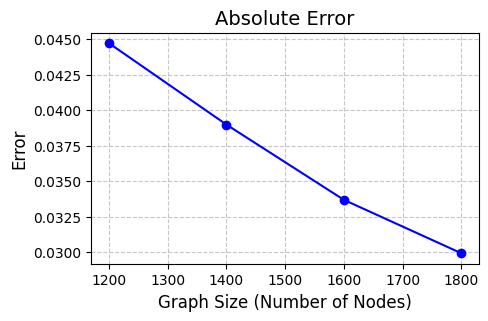

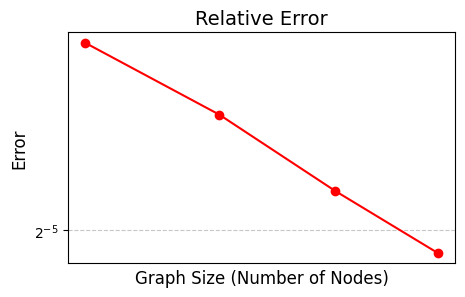

-0.9993139497172302


In [18]:
#Plot the absolute errors as the parameter of graph nodes changes.
plt.figure(figsize=(5, 3))
plt.plot(graph_sizes, errors, marker='o', linestyle='-', color='b')
plt.xlabel('Graph Size (Number of Nodes)', fontsize=12)
plt.ylabel('Error', fontsize=12)
plt.title('Absolute Error', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

#Plot the relative errors as the parameter of graph nodes changes.
plt.figure(figsize=(5, 3))
plt.plot(graph_sizes, errors, marker='o', linestyle='-', color='r')
plt.xscale('log', base=2)
plt.yscale('log', base=2)
plt.xlabel('Graph Size (Number of Nodes)', fontsize=12)
plt.ylabel('Error', fontsize=12)
plt.title('Relative Error', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()


slope, intercept = np.polyfit(np.log2(graph_sizes),np.log2(errors), 1)
convergence_rate = slope
print(convergence_rate)